## Convert Anndata Object to TrajectoryNet Format

TrajectoryNet is able to load Anndata objects with a few requirements.

1. The coordinate space to run TrajectoryNet on must be stored in `adata.obsm`
2. There must be a column in `adata.obs` titled `sample_labels` that labels each cell with the TrajectoryNet time.
3. (optionally) there can be `velocity_[embedding_name]` keys in `adata.obsm` this will be taken as velocity data in TrajectoryNet

This notebook takes an example from ScVelo and makes it runnable with TrajectoryNet.


In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import scvelo as scv
import scanpy as sc

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params("scvelo")  # for beautified visualization

### Load Data
Load an example dataset from `scvelo` and perform standard processing on it.

Note that the plotting of `scv.pl.velocity_embedding` with `basis=umap` and `basis=pca` is necessary for anndata to populate the `adata.obsm["velocity_umap"]` and `adata.obsm["velocity_pca"]` fields.

This will make both `pca` and `umap` valid embedding names to run with TrajectoryNet.

In [2]:
adata = scv.datasets.gastrulation_erythroid()

In [3]:
adata

AnnData object with n_obs × n_vars = 9815 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=1000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode="stochastic")
scv.tl.velocity_graph(adata)

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
Logarithmized X.
computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:01:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/6 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:01:39) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:11) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


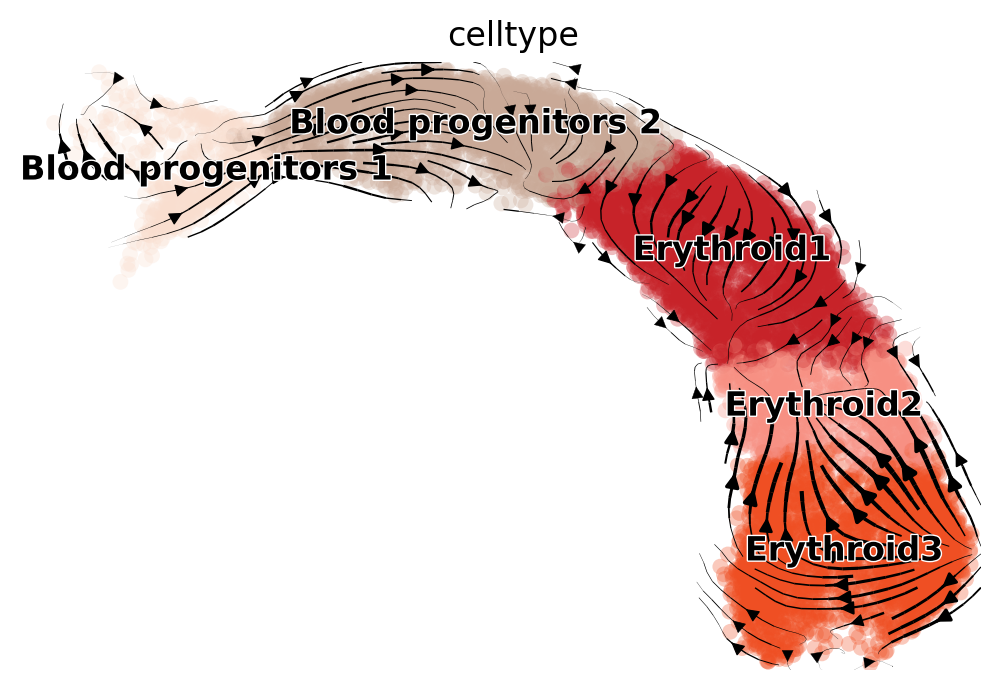

In [5]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="celltype")

computing velocity embedding
    finished (0:00:26) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


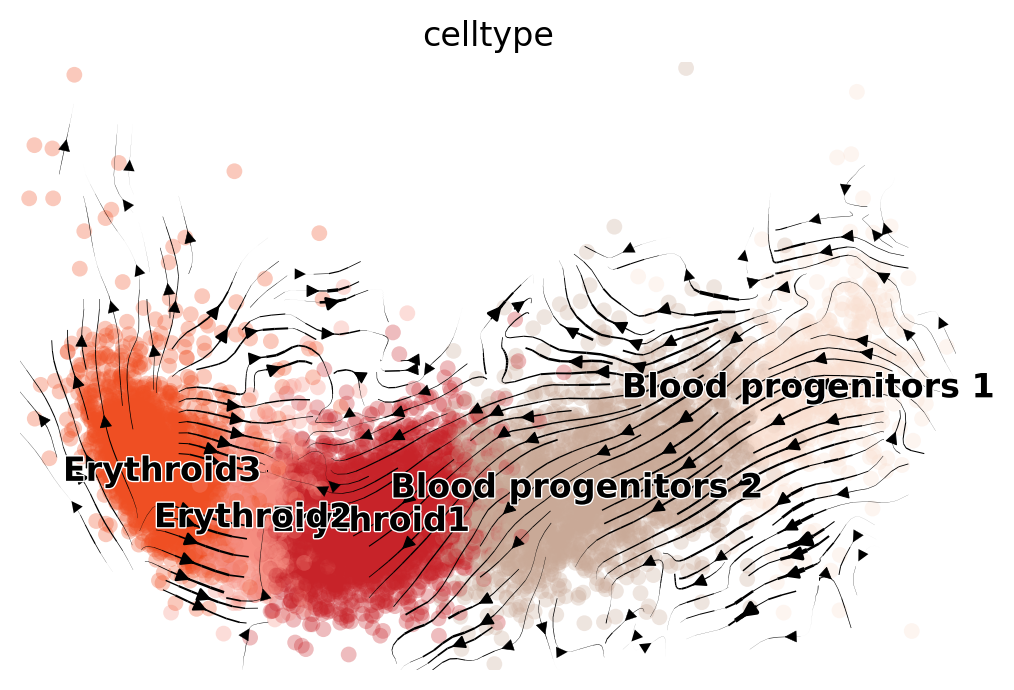

In [6]:
scv.pl.velocity_embedding_stream(adata, basis="pca", color="celltype")

### Add `sample_labels` key

Next we add the sample_labels key to `adata.obs` here we are using the blood cell type progression as an example, but we may want to use actual time. In general `sample_labels` should be increasing integers from zero with no gaps. While it is possible to run TrajectoryNet with this not true, it is more difficult.

In [7]:
adata.obs["sample_labels"] = adata.obs["celltype"].replace(
    {
        "Blood progenitors 1": 0,
        "Blood progenitors 2": 1,
        "Erythroid1": 2,
        "Erythroid2": 3,
        "Erythroid3": 4,
    }
)

In [8]:
adata

AnnData object with n_obs × n_vars = 9815 × 1000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'sample_labels'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'celltype_colors', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'velocity_pca'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [9]:
adata.obs

,sample,stage,sequencing.batch,theiler,celltype,initial_size_spliced,initial_size_unspliced,initial_size,n_counts,velocity_self_transition,sample_labels
AAAGATCTCTCGAA,2,E7.5,1,TS11,Blood progenitors 2,9480.0,702.0,9480.0,11793.531250,0.156355,1
AATCTCACTGCTTT,2,E7.5,1,TS11,Blood progenitors 2,7055.0,721.0,7055.0,11664.036133,0.218191,1
AATGGCTGAAGATG,2,E7.5,1,TS11,Blood progenitors 2,12131.0,702.0,12131.0,11812.558594,0.064245,1
ACACATCTGTCAAC,2,E7.5,1,TS11,Blood progenitors 2,9148.0,643.0,9148.0,11837.477539,0.109443,1
ACGACAACTGGAGG,2,E7.5,1,TS11,Blood progenitors 2,4998.0,302.0,4998.0,11779.755859,0.174271,1
...,...,...,...,...,...,...,...,...,...,...,...
TTTCACGACTGGTA,37,E8.5,3,TS12,Erythroid3,6949.0,350.0,6949.0,12015.311523,0.028123,4
TTTCAGTGCGAGTT,37,E8.5,3,TS12,Erythroid3,15140.0,631.0,15140.0,11947.122070,0.237394,4
TTTCGAACGGTGAG,37,E8.5,3,TS12,Erythroid3,19663.0,905.0,19663.0,11973.661133,0.032381,4
TTTCGAACTAACCG,37,E8.5,3,TS12,Erythroid3,13046.0,561.0,13046.0,11973.789062,0.012990,4


### Write File

TrajectoryNet will read this file in so we need to remember the path to it. "We now have a valid object to run TrajectoryNet on we can use `embedding_name = "pca"` or `embedding_name = "umap"`

In [10]:
adata.write_h5ad("adata.h5ad")

### Running TrajectoryNet

TrajectoryNet is currently setup to run from the commandline only. Below are some examples of what you might want to run. This will train TrajectoryNet for the specified number of iterations `niter` and will save logs and other useful information in the save directory (in this case `results/tmp` which can be used for future processing.

Some useful parameters:
* `--vecint` specifies the velocity regularization weight.
* `--sl2int` specifies the frobenius norm $\|f\|_2^2$ also known as energy regularization when combined with `--JFrobint` $\|J\|_2$ where $J$ is the Jacobian of F
* `--top_k_reg` specifies the weight of the density regularization as specified in the paper.
* `--training_noise` adds gaussian nose to each training point with a specified standard deviation. This helps to regularize the paths especially when there are very few points.

There are many other potential paramters, and these can be found in `TrajectoryNet/parse.py` in the source, or explored using:
```
python -m TrajectoryNet.main --help
```

In [ ]:
!python -m TrajectoryNet.main --dataset adata.h5ad \
        --embedding_name "pca" \
        --max_dim 10 \
        --niter 10000 \
        --vecint 1e-4 \
        --save results/tmp

In [ ]:
!python -m TrajectoryNet.eval --dataset adata.h5ad \
        --embedding_name "pca" \
        --max_dim 10 \
        --niter 10000 \
        --vecint 1e-4 \
        --save results/tmp